# Задание 1.1 - Метод К-ближайших соседей (K-neariest neighbor classifier)

В первом задании вы реализуете один из простейших алгоритмов машинного обучения - классификатор на основе метода K-ближайших соседей.
Мы применим его к задачам
- бинарной классификации (то есть, только двум классам)
- многоклассовой классификации (то есть, нескольким классам)

Так как методу необходим гиперпараметр (hyperparameter) - количество соседей, мы выберем его на основе кросс-валидации (cross-validation).

Наша основная задача - научиться пользоваться numpy и представлять вычисления в векторном виде, а также ознакомиться с основными метриками, важными для задачи классификации.

Перед выполнением задания:
- запустите файл `download_data.sh`, чтобы скачать данные, которые мы будем использовать для тренировки
- установите все необходимые библиотеки, запустив `pip install -r requirements.txt` (если раньше не работали с `pip`, вам сюда - https://pip.pypa.io/en/stable/quickstart/)

Если вы раньше не работали с numpy, вам может помочь tutorial. Например этот:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn
from knn import KNN
from metrics import binary_classification_metrics, multiclass_accuracy

# Загрузим и визуализируем данные

В задании уже дана функция `load_svhn`, загружающая данные с диска. Она возвращает данные для тренировки и для тестирования как numpy arrays.

Мы будем использовать цифры из датасета Street View House Numbers (SVHN, http://ufldl.stanford.edu/housenumbers/), чтобы решать задачу хоть сколько-нибудь сложнее MNIST.

In [3]:
train_X, train_y, test_X, test_y = load_svhn("data", max_train=1000, max_test=100)

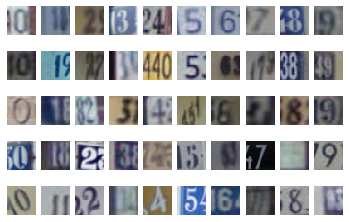

In [4]:
samples_per_class = 5  # Number of samples per class to visualize
plot_index = 1
for example_index in range(samples_per_class):
    for class_index in range(10):
        plt.subplot(5, 10, plot_index)
        image = train_X[train_y == class_index][example_index]
        plt.imshow(image.astype(np.uint8))
        plt.axis('off')
        plot_index += 1

# Сначала реализуем KNN для бинарной классификации

В качестве задачи бинарной классификации мы натренируем модель, которая будет отличать цифру 0 от цифры 9.

In [5]:
# First, let's prepare the labels and the source data

# Only select 0s and 9s
binary_train_mask = (train_y == 0) | (train_y == 9)
binary_train_X = train_X[binary_train_mask]
binary_train_y = train_y[binary_train_mask] == 0

binary_test_mask = (test_y == 0) | (test_y == 9)
binary_test_X = test_X[binary_test_mask]
binary_test_y = test_y[binary_test_mask] == 0

# Reshape to 1-dimensional array [num_samples, 32*32*3]
binary_train_X = binary_train_X.reshape(binary_train_X.shape[0], -1)
binary_test_X = binary_test_X.reshape(binary_test_X.shape[0], -1)

In [6]:
# Create the classifier and call fit to train the model
# KNN just remembers all the data
knn_classifier = KNN(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

## Пришло время написать код! 

Последовательно реализуйте функции `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops`
в файле `knn.py`.

Эти функции строят массив расстояний между всеми векторами в тестовом наборе и в тренировочном наборе.  
В результате они должны построить массив размера `(num_test, num_train)`, где координата `[i][j]` соотвествует расстоянию между i-м вектором в test (`test[i]`) и j-м вектором в train (`train[j]`).

**Обратите внимание** Для простоты реализации мы будем использовать в качестве расстояния меру L1 (ее еще называют [Manhattan distance](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2)).

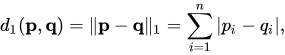

In [7]:
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))

In [8]:
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))


In [9]:
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))

In [10]:
# Lets look at the performance difference
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

19.7 ms ± 594 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
6.75 ms ± 122 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.2 ms ± 104 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
prediction = knn_classifier.predict(binary_test_X)

In [12]:
precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("KNN with k = %s" % knn_classifier.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

KNN with k = 1
Accuracy: 0.56, Precision: 0.67, Recall: 0.73, F1: 0.70


In [13]:
# Let's put everything together and run KNN with k=3 and see how we do
knn_classifier_3 = KNN(k=3)
knn_classifier_3.fit(binary_train_X, binary_train_y)
prediction = knn_classifier_3.predict(binary_test_X)

precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("KNN with k = %s" % knn_classifier_3.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

KNN with k = 3
Accuracy: 0.56, Precision: 0.67, Recall: 0.73, F1: 0.70


# Кросс-валидация (cross-validation)

Попробуем найти лучшее значение параметра k для алгоритма KNN! 

Для этого мы воспользуемся k-fold cross-validation (https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation). Мы разделим тренировочные данные на 5 фолдов (folds), и по очереди будем использовать каждый из них в качестве проверочных данных (validation data), а остальные -- в качестве тренировочных (training data).

В качестве финальной оценки эффективности k мы усредним значения F1 score на всех фолдах.
После этого мы просто выберем значение k с лучшим значением метрики.

*Бонус*: есть ли другие варианты агрегировать F1 score по всем фолдам? Напишите плюсы и минусы в клетке ниже.

In [14]:
# Find the best k using cross-validation based on F1 score
num_folds = 5
train_folds_X = []
train_folds_y = []

# Split the training data in 5 folds and store them in train_folds_X/train_folds_y
num_train = binary_train_X.shape[0]
delta_i = num_train // num_folds

valid_indexes = [range(n * delta_i, (n + 1) * delta_i) for n in range(num_folds)]
train_indexes = [list(set(range(num_train)) - set(valid_ind)) for valid_ind in valid_indexes]


k_choices = [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]
k_to_f1 = {}  # dict mapping k values to mean F1 scores (int -> float)
for k in k_choices:
    # Go through every fold and use it for testing and all other folds for training
    # Perform training and produce F1 score metric on the validation dataset
    # Average F1 from all the folds and write it into k_to_f1
    f1_avr = 0
    for num in range(num_folds):
        knn_classifier = KNN(k=k)
        knn_classifier.fit(binary_train_X[train_indexes[num]], binary_train_y[train_indexes[num]])
        prediction = knn_classifier.predict(binary_train_X[valid_indexes[num]])

        precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_train_y[valid_indexes[num]])
        f1_avr += f1
    
    f1_avr /= num_folds
    k_to_f1[k] = f1_avr
    

for k in sorted(k_to_f1, key=k_to_f1.get, reverse=True):
    print('k = %d, f1 = %f' % (k, k_to_f1[k]))

k = 3, f1 = 0.683108
k = 1, f1 = 0.673180
k = 20, f1 = 0.651463
k = 25, f1 = 0.647727
k = 15, f1 = 0.632905
k = 50, f1 = 0.626737
k = 10, f1 = 0.612388
k = 5, f1 = 0.611453
k = 8, f1 = 0.580125
k = 2, f1 = 0.533228


### Проверим, как хорошо работает лучшее значение k на тестовых данных (test data)

In [15]:
# TODO Set the best k to the best value found by cross-validation
best_k = 3

best_knn_classifier = KNN(k=best_k)
best_knn_classifier.fit(binary_train_X, binary_train_y)
prediction = best_knn_classifier.predict(binary_test_X)

precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("Best KNN with k = %s" % best_k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

Best KNN with k = 3
Accuracy: 0.56, Precision: 0.67, Recall: 0.73, F1: 0.70


# Многоклассовая классификация (multi-class classification)

Переходим к следующему этапу - классификации на каждую цифру.

In [16]:
# Now let's use all 10 classes
train_X = train_X.reshape(train_X.shape[0], -1)
test_X = test_X.reshape(test_X.shape[0], -1)

knn_classifier = KNN(k=1)
knn_classifier.fit(train_X, train_y)

In [17]:
# TODO: Implement predict_labels_multiclass
predict = knn_classifier.predict(test_X)

In [18]:
# TODO: Implement multiclass_accuracy
accuracy = multiclass_accuracy(predict, test_y)
print("Accuracy: %4.2f" % accuracy)

Accuracy: 0.21


Снова кросс-валидация. Теперь нашей основной метрикой стала точность (accuracy), и ее мы тоже будем усреднять по всем фолдам.

In [19]:
# Find the best k using cross-validation based on accuracy
num_folds = 5
train_folds_X = []
train_folds_y = []

# Split the training data in 5 folds and store them in train_folds_X/train_folds_y
num_train = binary_train_X.shape[0]
delta_i = num_train // num_folds

valid_indexes = [range(n * delta_i, (n + 1) * delta_i) for n in range(num_folds)]
train_indexes = [list(set(range(num_train)) - set(valid_ind)) for valid_ind in valid_indexes]

k_choices = [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]
k_to_accuracy = {}

for k in k_choices:
    # Go through every fold and use it for testing and all other folds for validation
    # Perform training and produce accuracy metric on the validation dataset
    # Average accuracy from all the folds and write it into k_to_accuracy
    accuracy_avr = 0
    for num in range(num_folds):
        knn_classifier = KNN(k=k)
        knn_classifier.fit(train_X[train_indexes[num]], train_y[train_indexes[num]])
        prediction = knn_classifier.predict(train_X[valid_indexes[num]])

        accuracy = multiclass_accuracy(prediction, train_y[valid_indexes[num]])
        accuracy_avr += accuracy
    
    accuracy_avr /= num_folds
    k_to_accuracy[k] = accuracy_avr


for k in sorted(k_to_accuracy, key=k_to_accuracy.get, reverse=True):
    print('k = %d, accuracy = %f' % (k, k_to_accuracy[k]))

k = 1, accuracy = 0.233333
k = 2, accuracy = 0.225000
k = 8, accuracy = 0.225000
k = 20, accuracy = 0.208333
k = 5, accuracy = 0.200000
k = 15, accuracy = 0.191667
k = 3, accuracy = 0.183333
k = 10, accuracy = 0.175000
k = 25, accuracy = 0.158333
k = 50, accuracy = 0.150000


### Финальный тест - классификация на 10 классов на тестовой выборке (test data)

Если все реализовано правильно, вы должны увидеть точность не менее **0.2**.

In [20]:
best_k = 2

best_knn_classifier = KNN(k=best_k)
best_knn_classifier.fit(train_X, train_y)
prediction = best_knn_classifier.predict(test_X)

# Accuracy should be around 20%!
accuracy = multiclass_accuracy(prediction, test_y)
print("Accuracy: %4.2f" % accuracy)

Accuracy: 0.26
